<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/Depth_Anything_DA_SCARED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown 1trvLsQvXpsILHTZPR-FU5z6Au4YZLwRP
!mv gt_depths.npz /content/AF-SfMLearner/splits/endovis

!gdown 1FXSsXj2u-9BX9buZPvtLrd0FzwWnCvr6
!unzip -q SCARED_Images_Resized.zip

Downloading...
From (original): https://drive.google.com/uc?id=1trvLsQvXpsILHTZPR-FU5z6Au4YZLwRP
From (redirected): https://drive.google.com/uc?id=1trvLsQvXpsILHTZPR-FU5z6Au4YZLwRP&confirm=t&uuid=d05d5d71-6750-4869-a49c-89891cd6e2da
To: /content/gt_depths.npz
100% 811M/811M [00:11<00:00, 68.8MB/s]
mv: cannot move 'gt_depths.npz' to '/content/AF-SfMLearner/splits/endovis': No such file or directory
Downloading...
From (original): https://drive.google.com/uc?id=1FXSsXj2u-9BX9buZPvtLrd0FzwWnCvr6
From (redirected): https://drive.google.com/uc?id=1FXSsXj2u-9BX9buZPvtLrd0FzwWnCvr6&confirm=t&uuid=b5ad0185-29c6-427a-bc19-93d21762130f
To: /content/SCARED_Images_Resized.zip
100% 4.53G/4.53G [01:05<00:00, 69.3MB/s]


In [2]:
!git clone https://github.com/mobarakol/AF-SfMLearner.git

Cloning into 'AF-SfMLearner'...
remote: Enumerating objects: 389, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 389 (delta 111), reused 153 (delta 81), pack-reused 183 (from 1)
Receiving objects: 100% (389/389), 4.88 MiB | 16.83 MiB/s, done.
Resolving deltas: 100% (185/185), done.


sample size: 551
gt_depths: (551, 1024, 1280)
test["color", 0, 0]: torch.Size([3, 256, 320]) tensor(0.) tensor(1.)
test["color_aug", 0, 0]: torch.Size([3, 256, 320]) tensor(0.) tensor(1.) (1024, 1280)


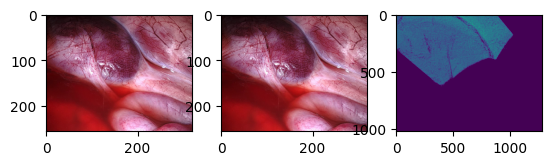

In [31]:
from __future__ import absolute_import, division, print_function

import glob
import os
import random
import numpy as np
from PIL import Image  # using pillow-simd for increased speed
from PIL import ImageFile
import cv2


import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

ImageFile.LOAD_TRUNCATED_IMAGES=True

def readlines(filename):
    """Read all the lines in a text file and return as a list
    """
    with open(filename, 'r') as f:
        lines = f.read().splitlines()
    return lines

def pil_loader(path):
    # open path as file to avoid ResourceWarning
    # (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')


class MonoDataset(data.Dataset):
    """Superclass for monocular dataloaders

    Args:
        data_path
        filenames
        height
        width
        frame_idxs
        num_scales
        is_train
        img_ext
    """
    def __init__(self,
                 data_path,
                 filenames,
                 height,
                 width,
                 frame_idxs,
                 num_scales,
                 is_train=False,
                 img_ext='.png'):
        super(MonoDataset, self).__init__()

        self.data_path = data_path
        self.filenames = filenames
        self.height = height
        self.width = width
        self.num_scales = num_scales
        # self.interp = Image.ANTIALIAS
        self.interp = Image.LANCZOS

        self.frame_idxs = frame_idxs

        self.is_train = is_train
        self.img_ext = img_ext

        self.loader = pil_loader
        self.to_tensor = transforms.ToTensor()

        # We need to specify augmentations differently in newer versions of torchvision.
        # We first try the newer tuple version; if this fails we fall back to scalars
        try:
            self.brightness = (0.8, 1.2)
            self.contrast = (0.8, 1.2)
            self.saturation = (0.8, 1.2)
            self.hue = (-0.1, 0.1)
            transforms.transforms.ColorJitter(self.brightness,self.contrast,self.saturation,self.hue)
        except TypeError:
            self.brightness = 0.2
            self.contrast = 0.2
            self.saturation = 0.2
            self.hue = 0.1

        self.resize = {}
        for i in range(self.num_scales):
            s = 2 ** i
            self.resize[i] = transforms.Resize((self.height // s, self.width // s),
                                               interpolation=self.interp)
        self.load_depth = self.check_depth()

    def preprocess(self, inputs, color_aug):
        """Resize colour images to the required scales and augment if required

        We create the color_aug object in advance and apply the same augmentation to all
        images in this item. This ensures that all images input to the pose network receive the
        same augmentation.
        """
        for k in list(inputs):
            frame = inputs[k]
            if "color" in k:
                n, im, i = k
                for i in range(self.num_scales):
                    inputs[(n, im, i)] = self.resize[i](inputs[(n, im, i - 1)])

        for k in list(inputs):
            f = inputs[k]
            if "color" in k:
                n, im, i = k
                inputs[(n, im, i)] = self.to_tensor(f)
                inputs[(n + "_aug", im, i)] = self.to_tensor(color_aug(f))

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        """Returns a single training item from the dataset as a dictionary.

        Values correspond to torch tensors.
        Keys in the dictionary are either strings or tuples:

            ("color", <frame_id>, <scale>)          for raw colour images,
            ("color_aug", <frame_id>, <scale>)      for augmented colour images,
            ("K", scale) or ("inv_K", scale)        for camera intrinsics,
            "stereo_T"                              for camera extrinsics, and
            "depth_gt"                              for ground truth depth maps.

        <frame_id> is either:
            an integer (e.g. 0, -1, or 1) representing the temporal step relative to 'index',
        or
            "s" for the opposite image in the stereo pair.

        <scale> is an integer representing the scale of the image relative to the fullsize image:
            -1      images at native resolution as loaded from disk
            0       images resized to (self.width,      self.height     )
            1       images resized to (self.width // 2, self.height // 2)
            2       images resized to (self.width // 4, self.height // 4)
            3       images resized to (self.width // 8, self.height // 8)
        """
        inputs = {}

        do_color_aug = self.is_train and random.random() > 0.5
        do_flip = self.is_train and random.random() > 0.5
        line = self.filenames[index].split()
        folder = line[0]
        sequence = folder[7]
        keyframe = folder[-1]
        inputs["sequence"] = torch.from_numpy(np.array(int(sequence)))
        inputs["keyframe"] = torch.from_numpy(np.array(int(keyframe)))

        if len(line) == 3:
            frame_index = int(line[1])
        else:
            frame_index = 0

        if len(line) == 3:
            side = line[2]
        else:
            side = None

        inputs["frame_id"] = torch.from_numpy(np.array(frame_index))
        for idx, i in enumerate(self.frame_idxs):
            if i == "s":
                other_side = {"r": "l", "l": "r"}[side]
                inputs[("color", i, -1)] = self.get_color(folder, frame_index, other_side, do_flip)
            else:
                inputs[("color", i, -1)] = self.get_color(folder, frame_index + i, side, do_flip)

            if idx == 0:
                color_path = self.get_image_path(folder, frame_index + i, side)
                inputs['path'] = color_path


        # adjusting intrinsics to match each scale in the pyramid
        for scale in range(self.num_scales):
            K = self.K.copy()
            K[0, :] *= self.width // (2 ** scale)
            K[1, :] *= self.height // (2 ** scale)


            inv_K = np.linalg.pinv(K)

            inputs[("K", scale)] = torch.from_numpy(K)
            inputs[("inv_K", scale)] = torch.from_numpy(inv_K)

        if do_color_aug:
            color_aug = transforms.ColorJitter(self.brightness, self.contrast, self.saturation, self.hue)
        else:
            color_aug = (lambda x: x)

        self.preprocess(inputs, color_aug)
        for i in self.frame_idxs:
            del inputs[("color", i, -1)]
            del inputs[("color_aug", i, -1)]

        if self.load_depth:
            depth_gt = self.get_depth(folder, frame_index, side, do_flip)
            inputs["depth_gt"] = np.expand_dims(depth_gt, 0)
            inputs["depth_gt"] = torch.from_numpy(inputs["depth_gt"].astype(np.float32))

        if "s" in self.frame_idxs:
            stereo_T = np.eye(4, dtype=np.float32)
            baseline_sign = -1 if do_flip else 1
            side_sign = -1 if side == "l" else 1
            stereo_T[0, 3] = side_sign * baseline_sign * 0.1

            inputs["stereo_T"] = torch.from_numpy(stereo_T)
        return inputs

    def get_color(self, folder, frame_index, side, do_flip):
        raise NotImplementedError

    def check_depth(self):
        raise NotImplementedError

    def get_depth(self, folder, frame_index, side, do_flip):
        raise NotImplementedError

class SCAREDDataset(MonoDataset):
    def __init__(self, *args, **kwargs):
        super(SCAREDDataset, self).__init__(*args, **kwargs)

        self.K = np.array([[0.82, 0, 0.5, 0],
                           [0, 1.02, 0.5, 0],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]], dtype=np.float32)

        # self.full_res_shape = (1280, 1024)
        self.side_map = {"2": 2, "3": 3, "l": 2, "r": 3}

    def check_depth(self):

        return False

    def get_color(self, folder, frame_index, side, do_flip):
        color = self.loader(self.get_image_path(folder, frame_index, side))

        if do_flip:
            color = color.transpose(pil.FLIP_LEFT_RIGHT)

        return color


class SCAREDRAWDataset(SCAREDDataset):
    def __init__(self, *args, **kwargs):
        super(SCAREDRAWDataset, self).__init__(*args, **kwargs)

    def get_image_path(self, folder, frame_index, side):
        f_str = "{:010d}{}".format(frame_index, self.img_ext)
        image_path = os.path.join(
            self.data_path, folder, "image_0{}/data".format(self.side_map[side]), f_str)

        return image_path

    def get_depth(self, folder, frame_index, side, do_flip):
        f_str = "scene_points{:06d}.tiff".format(frame_index-1)

        depth_path = os.path.join(
            self.data_path,
            folder,
            "image_0{}/data/groundtruth".format(self.side_map[side]),
            f_str)

        depth_gt = cv2.imread(depth_path, 3)
        depth_gt = depth_gt[:, :, 0]
        depth_gt = depth_gt[0:1024, :]
        if do_flip:
            depth_gt = np.fliplr(depth_gt)

        return depth_gt

data_path = 'SCARED_Images_Resized'
file_path = '/content/AF-SfMLearner/splits/endovis/test_files.txt'
gt_path = '/content/gt_depths.npz'
filenames = readlines(file_path)
dataset_scared = SCAREDRAWDataset(data_path, filenames,256,320,[0], 4, is_train=False)
dataloader = DataLoader(dataset_scared, 16, shuffle=False, num_workers=2, pin_memory=True, drop_last=False)
print('sample size:', len(dataset_scared))

gt_depths = np.load(gt_path, fix_imports=True, encoding='latin1')["data"]
print('gt_depths:', gt_depths.shape)
test = dataset_scared[0]
plt.subplot(131); plt.imshow(test['color', 0, 0].permute(1,2,0))
plt.subplot(132); plt.imshow(test["color_aug", 0, 0].permute(1,2,0))
plt.subplot(133); plt.imshow(gt_depths[0])

print('test["color", 0, 0]:', test["color", 0, 0].shape, test["color", 0, 0].min(), test["color", 0, 0].max())
print('test["color_aug", 0, 0]:', test["color_aug", 0, 0].shape, test["color_aug", 0, 0].min(), test["color_aug", 0, 0].max(), gt_depths[0].shape)

pred_disps: (551, 420, 518) gt_depths: (551, 1024, 1280)
 Scaling ratios | med: 505.059 | std: 0.304

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
&   0.106  &   1.392  &   8.752  &   0.147  &   0.893  &   0.976  &   0.993  \\


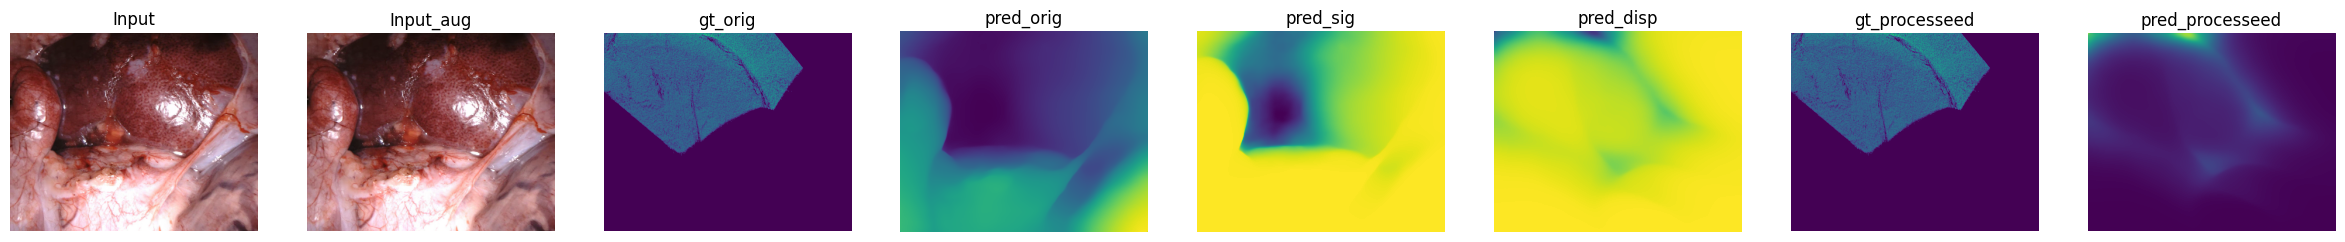

In [36]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
from torch import nn

def disp_to_depth(disp, min_depth=0.1, max_depth=150):
    """Convert network's sigmoid output into depth prediction
    The formula for this conversion is given in the 'additional considerations'
    section of the paper.
    """
    min_disp = 1 / max_depth
    max_disp = 1 / min_depth
    scaled_disp = min_disp + (max_disp - min_disp) * disp
    depth = 1 / scaled_disp
    return scaled_disp, depth

def compute_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_path = 'SCARED_Images_Resized'
file_path = '/content/AF-SfMLearner/splits/endovis/test_files.txt'
gt_path = '/content/gt_depths.npz'
filenames = readlines(file_path)
dataset_scared = SCAREDRAWDataset(data_path, filenames,256,320,[0], 4, is_train=False)
dataloader = DataLoader(dataset_scared, 16, shuffle=False, num_workers=2, pin_memory=True, drop_last=False)

image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
depth_model = DepthAnythingForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")
depth_model.to(device)
depth_model.eval()
# prepare image for the model
MIN_DEPTH = 1e-3
MAX_DEPTH = 150
pred_disps = []

with torch.no_grad():
    for sample_batch in dataloader:
        # depth_gt =sample_batch['depth_gt'].to(device)
        inputs = image_processor(images=sample_batch['color', 0, 0], return_tensors="pt", do_rescale=False).to(device)
        outputs = depth_model(**inputs)
        predicted_depth = outputs.predicted_depth.unsqueeze(1)
        predicted_depth_sig = nn.Sigmoid()(predicted_depth)
        # print('predicted_depth', predicted_depth_sig.shape)
        pred_disp, _ = disp_to_depth(predicted_depth_sig)
        # print('pred_disp:', pred_disp.shape)
        pred_disp = pred_disp.cpu()[:, 0].numpy()
        pred_disps.append(pred_disp)
        # gt_depths.append(sample_batch['depth_gt'])
        # prediction = torch.nn.functional.interpolate(predicted_depth.unsqueeze(1),size=inputs['pixel_values'].shape[2:],mode="bicubic",align_corners=False)

    pred_disps = np.concatenate(pred_disps)
    # gt_depths = np.concatenate(gt_depths).squeeze()

print('pred_disps:',pred_disps.shape, 'gt_depths:',gt_depths.shape)
errors = []
ratios = []

for i in range(pred_disps.shape[0]):
    gt_depth = gt_depths[i]
    gt_height, gt_width = gt_depth.shape[:2]

    pred_disp = pred_disps[i]
    # print('pred_disp1:', pred_disp.shape)
    pred_disp = cv2.resize(pred_disp, (gt_width, gt_height))
    # print('pred_disp2:', pred_disp.shape)
    pred_depth = 1/pred_disp
    # print('pred_disp3:', pred_disp.shape)
    mask = np.logical_and(gt_depth > MIN_DEPTH, gt_depth < MAX_DEPTH)
    # print('mask:', mask.shape, 'pred_depth:', pred_depth.shape)
    # print('pred_depth8:',pred_depth.shape, 'gt_depth8:',gt_depth.shape)
    if i == 0:
        vis_gt_depth = gt_depth
        vis_pred_depth = pred_depth
    pred_depth = pred_depth[mask]
    gt_depth = gt_depth[mask]
    # print('pred_depth9:',pred_depth.shape, 'gt_depth9:',gt_depth.shape)

    ratio = np.median(gt_depth) / np.median(pred_depth)
    ratios.append(ratio)
    pred_depth *= ratio
    # print('pred_depth10:',pred_depth.shape, 'gt_depth10:',gt_depth.shape)
    pred_depth[pred_depth < MIN_DEPTH] = MIN_DEPTH
    pred_depth[pred_depth > MAX_DEPTH] = MAX_DEPTH
    # print('pred_depth11:',pred_depth.shape, 'gt_depth11:',gt_depth.shape)

    errors.append(compute_errors(gt_depth, pred_depth))


ratios = np.array(ratios)
med = np.median(ratios)
print(" Scaling ratios | med: {:0.3f} | std: {:0.3f}".format(med, np.std(ratios / med)))

mean_errors = np.array(errors).mean(0)

print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
print(("&{: 8.3f}  " * 7).format(*mean_errors.tolist()) + "\\\\")

plt.rcParams['figure.figsize'] = [30, 8]
plt.subplot(181); plt.axis('OFF'); plt.title('Input'); plt.imshow(sample_batch['color', 0, 0][0].permute(1,2,0))
plt.subplot(182); plt.axis('OFF'); plt.title('Input_aug'); plt.imshow(sample_batch["color_aug", 0, 0][0].permute(1,2,0))
plt.subplot(183); plt.axis('OFF'); plt.title('gt_orig'); plt.imshow(gt_depths[0])
plt.subplot(184); plt.axis('OFF'); plt.title('pred_orig'); plt.imshow(predicted_depth[0][0].cpu())
plt.subplot(185); plt.axis('OFF'); plt.title('pred_sig'); plt.imshow(predicted_depth_sig[0][0].cpu())
plt.subplot(186); plt.axis('OFF'); plt.title('pred_disp'); plt.imshow(pred_disps[0])
plt.subplot(187); plt.axis('OFF'); plt.title('gt_processeed'); plt.imshow(vis_gt_depth)
plt.subplot(188); plt.axis('OFF'); plt.title('pred_processeed'); plt.imshow(vis_pred_depth)

pred_disps: (551, 252, 308) gt_depths: (551, 1024, 1280)
 Scaling ratios | med: 503.603 | std: 0.303

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
&   0.105  &   1.370  &   8.675  &   0.146  &   0.894  &   0.977  &   0.994  \\


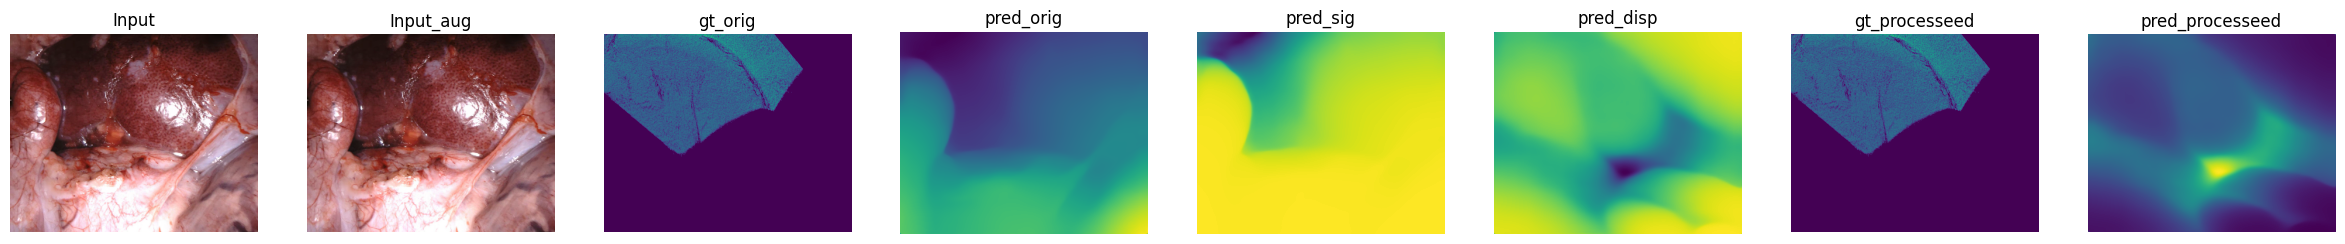

In [47]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
from torch import nn

def disp_to_depth(disp, min_depth=0.1, max_depth=150):
    """Convert network's sigmoid output into depth prediction
    The formula for this conversion is given in the 'additional considerations'
    section of the paper.
    """
    min_disp = 1 / max_depth
    max_disp = 1 / min_depth
    scaled_disp = min_disp + (max_disp - min_disp) * disp
    depth = 1 / scaled_disp
    return scaled_disp, depth

def compute_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_path = 'SCARED_Images_Resized'
file_path = '/content/AF-SfMLearner/splits/endovis/test_files.txt'
gt_path = '/content/gt_depths.npz'
filenames = readlines(file_path)
dataset_scared = SCAREDRAWDataset(data_path, filenames,256,320,[0], 4, is_train=False)
dataloader = DataLoader(dataset_scared, 16, shuffle=False, num_workers=2, pin_memory=True, drop_last=False)

image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
depth_model = DepthAnythingForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")
depth_model.to(device)
depth_model.eval()
# prepare image for the model
MIN_DEPTH = 1e-3
MAX_DEPTH = 150
pred_disps = []

with torch.no_grad():
    for sample_batch in dataloader:

        # inputs = image_processor(images=sample_batch['color', 0, 0], return_tensors="pt", do_rescale=False).to(device)
        # outputs = depth_model(**inputs)
        outputs = depth_model(sample_batch['color', 0, 0].to(device))
        predicted_depth = outputs.predicted_depth.unsqueeze(1)

        predicted_depth_sig = nn.Sigmoid()(predicted_depth)
        pred_disp, _ = disp_to_depth(predicted_depth_sig)
        pred_disp = pred_disp.cpu()[:, 0].numpy()

        # pred_disp = predicted_depth.cpu()[:, 0].numpy()
        pred_disps.append(pred_disp)
        # gt_depths.append(sample_batch['depth_gt'])
        # prediction = torch.nn.functional.interpolate(predicted_depth.unsqueeze(1),size=inputs['pixel_values'].shape[2:],mode="bicubic",align_corners=False)

    pred_disps = np.concatenate(pred_disps)
    # gt_depths = np.concatenate(gt_depths).squeeze()

print('pred_disps:',pred_disps.shape, 'gt_depths:',gt_depths.shape)
errors = []
ratios = []

for i in range(pred_disps.shape[0]):
    gt_depth = gt_depths[i]
    gt_height, gt_width = gt_depth.shape[:2]

    pred_disp = pred_disps[i]

    pred_disp = cv2.resize(pred_disp, (gt_width, gt_height))
    pred_depth = 1/pred_disp

    mask = np.logical_and(gt_depth > MIN_DEPTH, gt_depth < MAX_DEPTH)
    # print('mask:', mask.shape, 'pred_depth:', pred_depth.shape)
    # print('pred_depth8:',pred_depth.shape, 'gt_depth8:',gt_depth.shape)
    if i == 0:
        vis_gt_depth = gt_depth
        vis_pred_depth = pred_depth

    # print('pred_depth', pred_depth.shape)
    pred_depth = pred_depth[mask]
    gt_depth = gt_depth[mask]
    # print('pred_depth9:',pred_depth.shape, 'gt_depth9:',gt_depth.shape)

    ratio = np.median(gt_depth) / np.median(pred_depth)
    ratios.append(ratio)
    pred_depth *= ratio
    # print('pred_depth10:',pred_depth.shape, 'gt_depth10:',gt_depth.shape)
    pred_depth[pred_depth < MIN_DEPTH] = MIN_DEPTH
    pred_depth[pred_depth > MAX_DEPTH] = MAX_DEPTH
    # print('pred_depth11:',pred_depth.shape, 'gt_depth11:',gt_depth.shape)

    errors.append(compute_errors(gt_depth, pred_depth))


ratios = np.array(ratios)
med = np.median(ratios)
print(" Scaling ratios | med: {:0.3f} | std: {:0.3f}".format(med, np.std(ratios / med)))

mean_errors = np.array(errors).mean(0)

print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
print(("&{: 8.3f}  " * 7).format(*mean_errors.tolist()) + "\\\\")

plt.rcParams['figure.figsize'] = [30, 8]
plt.subplot(181); plt.axis('OFF'); plt.title('Input'); plt.imshow(sample_batch['color', 0, 0][0].permute(1,2,0))
plt.subplot(182); plt.axis('OFF'); plt.title('Input_aug'); plt.imshow(sample_batch["color_aug", 0, 0][0].permute(1,2,0))
plt.subplot(183); plt.axis('OFF'); plt.title('gt_orig'); plt.imshow(gt_depths[0])
plt.subplot(184); plt.axis('OFF'); plt.title('pred_orig'); plt.imshow(predicted_depth[0][0].cpu())
plt.subplot(185); plt.axis('OFF'); plt.title('pred_sig'); plt.imshow(predicted_depth_sig[0][0].cpu())
plt.subplot(186); plt.axis('OFF'); plt.title('pred_disp'); plt.imshow(pred_disps[0])
plt.subplot(187); plt.axis('OFF'); plt.title('gt_processeed'); plt.imshow(vis_gt_depth)
plt.subplot(188); plt.axis('OFF'); plt.title('pred_processeed'); plt.imshow(vis_pred_depth)

pred_disps: (551, 252, 308) gt_depths: (551, 1024, 1280)


<ipython-input-48-7a6d23a3c833>:88: RuntimeWarning: divide by zero encountered in divide
  pred_depth = 1/pred_disp


 Scaling ratios | med: 338.521 | std: 0.372

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
&   0.116  &   1.535  &   9.156  &   0.153  &   0.855  &   0.979  &   0.997  \\


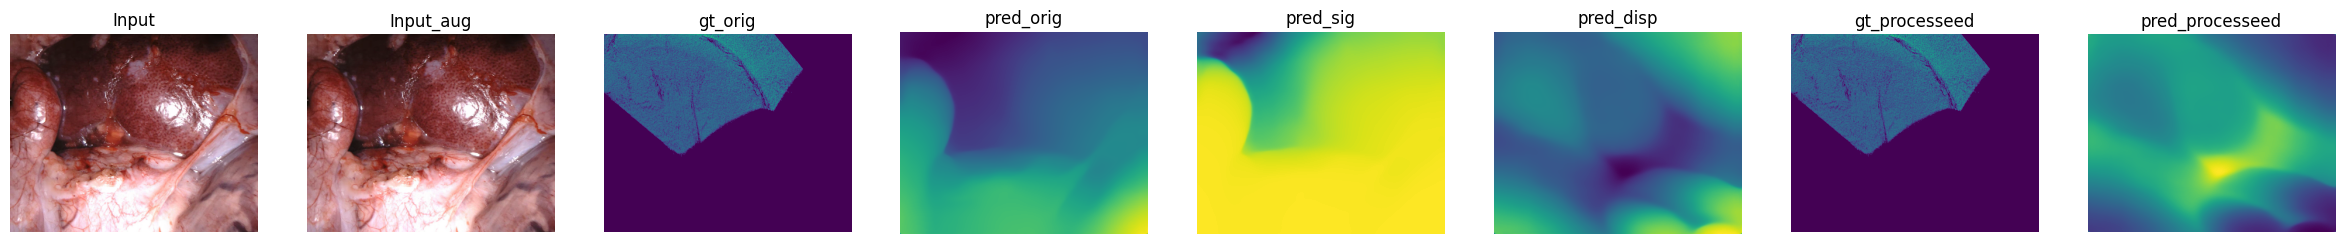

In [48]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
from torch import nn

def disp_to_depth(disp, min_depth=0.1, max_depth=150):
    """Convert network's sigmoid output into depth prediction
    The formula for this conversion is given in the 'additional considerations'
    section of the paper.
    """
    min_disp = 1 / max_depth
    max_disp = 1 / min_depth
    scaled_disp = min_disp + (max_disp - min_disp) * disp
    depth = 1 / scaled_disp
    return scaled_disp, depth

def compute_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_path = 'SCARED_Images_Resized'
file_path = '/content/AF-SfMLearner/splits/endovis/test_files.txt'
gt_path = '/content/gt_depths.npz'
filenames = readlines(file_path)
dataset_scared = SCAREDRAWDataset(data_path, filenames,256,320,[0], 4, is_train=False)
dataloader = DataLoader(dataset_scared, 16, shuffle=False, num_workers=2, pin_memory=True, drop_last=False)

image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
depth_model = DepthAnythingForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")
depth_model.to(device)
depth_model.eval()
# prepare image for the model
MIN_DEPTH = 1e-3
MAX_DEPTH = 150
pred_disps = []

with torch.no_grad():
    for sample_batch in dataloader:

        # inputs = image_processor(images=sample_batch['color', 0, 0], return_tensors="pt", do_rescale=False).to(device)
        # outputs = depth_model(**inputs)
        outputs = depth_model(sample_batch['color', 0, 0].to(device))
        predicted_depth = outputs.predicted_depth.unsqueeze(1)

        # predicted_depth_sig = nn.Sigmoid()(predicted_depth)
        # pred_disp, _ = disp_to_depth(predicted_depth_sig)
        # pred_disp = pred_disp.cpu()[:, 0].numpy()

        pred_disp = predicted_depth.cpu()[:, 0].numpy()
        pred_disps.append(pred_disp)
        # gt_depths.append(sample_batch['depth_gt'])
        # prediction = torch.nn.functional.interpolate(predicted_depth.unsqueeze(1),size=inputs['pixel_values'].shape[2:],mode="bicubic",align_corners=False)

    pred_disps = np.concatenate(pred_disps)
    # gt_depths = np.concatenate(gt_depths).squeeze()

print('pred_disps:',pred_disps.shape, 'gt_depths:',gt_depths.shape)
errors = []
ratios = []

for i in range(pred_disps.shape[0]):
    gt_depth = gt_depths[i]
    gt_height, gt_width = gt_depth.shape[:2]

    pred_disp = pred_disps[i]

    pred_disp = cv2.resize(pred_disp, (gt_width, gt_height))
    pred_depth = 1/pred_disp

    mask = np.logical_and(gt_depth > MIN_DEPTH, gt_depth < MAX_DEPTH)
    # print('mask:', mask.shape, 'pred_depth:', pred_depth.shape)
    # print('pred_depth8:',pred_depth.shape, 'gt_depth8:',gt_depth.shape)
    if i == 0:
        vis_gt_depth = gt_depth
        vis_pred_depth = pred_depth

    # print('pred_depth', pred_depth.shape)
    pred_depth = pred_depth[mask]
    gt_depth = gt_depth[mask]
    # print('pred_depth9:',pred_depth.shape, 'gt_depth9:',gt_depth.shape)

    ratio = np.median(gt_depth) / np.median(pred_depth)
    ratios.append(ratio)
    pred_depth *= ratio
    # print('pred_depth10:',pred_depth.shape, 'gt_depth10:',gt_depth.shape)
    pred_depth[pred_depth < MIN_DEPTH] = MIN_DEPTH
    pred_depth[pred_depth > MAX_DEPTH] = MAX_DEPTH
    # print('pred_depth11:',pred_depth.shape, 'gt_depth11:',gt_depth.shape)

    errors.append(compute_errors(gt_depth, pred_depth))


ratios = np.array(ratios)
med = np.median(ratios)
print(" Scaling ratios | med: {:0.3f} | std: {:0.3f}".format(med, np.std(ratios / med)))

mean_errors = np.array(errors).mean(0)

print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
print(("&{: 8.3f}  " * 7).format(*mean_errors.tolist()) + "\\\\")

plt.rcParams['figure.figsize'] = [30, 8]
plt.subplot(181); plt.axis('OFF'); plt.title('Input'); plt.imshow(sample_batch['color', 0, 0][0].permute(1,2,0))
plt.subplot(182); plt.axis('OFF'); plt.title('Input_aug'); plt.imshow(sample_batch["color_aug", 0, 0][0].permute(1,2,0))
plt.subplot(183); plt.axis('OFF'); plt.title('gt_orig'); plt.imshow(gt_depths[0])
plt.subplot(184); plt.axis('OFF'); plt.title('pred_orig'); plt.imshow(predicted_depth[0][0].cpu())
plt.subplot(185); plt.axis('OFF'); plt.title('pred_sig'); plt.imshow(predicted_depth_sig[0][0].cpu())
plt.subplot(186); plt.axis('OFF'); plt.title('pred_disp'); plt.imshow(pred_disps[0])
plt.subplot(187); plt.axis('OFF'); plt.title('gt_processeed'); plt.imshow(vis_gt_depth)
plt.subplot(188); plt.axis('OFF'); plt.title('pred_processeed'); plt.imshow(vis_pred_depth)